# Training Whisper with Huggingface 🤗

In my previous article, we learned about the new end-to-end speech recognition model developed by OpenAI: Whisper.

Today, we will go through the steps required to fine-tune a Whisper model using several Huggingface libraries. Furthermore, we will understand in detail how the Huggingface libraries take care of all the different steps under the hood, and how the model learns from the training examples.

But first let me clarify an important point: Whisper models are already trained on downstream tasks, which means that they can be used out-of-the-box to perform several tasks like language-to-language transcription, language-to-english translation, and language identification. But you will achieve better performance on specific distributions (language, domain, specific background noise, ...) if the model is fine-tuned on a a specific dataset.

If you want to learn more about the approach used, training data, model architecture and the extensive evaluation performed by the OpenAI team, [this](https://marinone94.github.io/Whisper-paper/) is the place to start! You will benefit much more from this post afterwards.

Since the scope of the article is to learn about the training process, we will fine-tune the smallest model available - [Whisper Tiny](https://huggingface.co/openai/whisper-tiny) - on the English subset of the [Fleurs](https://huggingface.co/datasets/google/fleurs) dataset. Whisper models have been trained largely on English data, so I don't expect to further improve the performance; still, it will be a good starting point to understand how the training process works, and it will allow everyone to verify the model's predictions. 

## TODO:
- fix requirements
- run full training
- analyze results and compare original and fine tuned model
- explore training mechanism under the hood (record a debugging video? screenshots? animation?)
- introduce next article
- fix "how to read" and package imports
- export plots? and add a bunch of images
- review and publish

## Environment setup

To reproduce the following examples, I recommend you to setup a virtual environment if you are running this notebook on your local machine. The code has been tested with the packages listed in the `requirements.txt` file on `Colab` and `Python 3.8.16`, so I cannot guarantee that it will run smoothly with other packages or Python versions (although it will mostly do with minimal adjustments).

In [ ]:
## Clean directories
## RUN WITH CARE!
# !rm -rf assets/ model/ wandb/

In [ ]:
# !python3.8 -m venv venv
# !source venv/bin/activate

In [ ]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4


In [ ]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


Let's check that the packages have been installed correctly, and see if a GPU is available.

In [ ]:
!pip3 freeze

absl-py==1.3.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.3.1
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.2.0
audioread==3.0.0
autograd==1.5
Babel==2.11.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.9
bokeh==2.3.3
branca==0.6.0
bs4==0.0.1
CacheControl==0.12.11
cachetools==5.2.1
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
cftime==1.6.2
chardet==4.0.0
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==2.2.0
cmake==3.22.6
cmdstanpy==1.0.8
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.3
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.3
cycler==0.11.0
cymem==2.0.7
Cython==0.29.33
daft==0.0.4
dask==2022.2.1
datascience==0.17.5
db-dtypes==1.0.5
dbus-python==1.2.16
debugpy==1.0.0
decorator==4.4.2
de

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Last, since the purpose of training a model is to use it afterwards, we will leverage the 🤗 hub to store it, so we can load it anywhere. Model and repo will be used in future articles, so don't skip these steps! First of all, you need to create an account on https://huggingface.co (even though - if you are reading this - chances are high you already have one).

Then, you can authenticate and create a repository. It is a standard git repo, and it leverages git-lfs to manage large files like the model wegiths. If git-lfs is not installed, let's install it so we can push our model later. Since on Colab it comes pre-installed, I commented out the installation cell.

In [ ]:
!git-lfs -v

git-lfs/3.3.0 (GitHub; linux amd64; go 1.19.3)


In [ ]:
# !curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
# !sudo apt-get install git-lfs

Then we can login to 🤗 and create the repo. The login token can be created on the [🤗 site](https://huggingface.co/settings/tokens). Make sure to give it `write` permissions, and a meaningful name. It is advisable to use differnt tokens for different scopes.

In [ ]:
!huggignface-cli login

In [ ]:
# feel free to edit the name
your_repo_name = "whisper-training-blog-test"

In [ ]:
!huggingface-cli repo create $your_repo_name

This will allow us to push the model during training, or after training is completed!

## How to read this article

Sections
What's for who
Code
Imports
...

## Training dataset

Fleurs is a dataset open-sourced by Google which contains approximately 2000 examples for each language. Each training set has around **10 hours** of supervision, and speakers of the training sets are different from the speakers of the dev and test sets.

This dataset has also been used to evaluate the translation capabilities of Whisper models, since all sentences are translated in all languages and can be matched using their ids.

Before proceeding with the training, let's take a look at the data.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("google/fleurs", "sv_se", streaming=True)

In [ ]:
dataset

{'train': <datasets.iterable_dataset.IterableDataset at 0x7f239c324af0>,
 'validation': <datasets.iterable_dataset.IterableDataset at 0x7f239c3246a0>,
 'test': <datasets.iterable_dataset.IterableDataset at 0x7f239b8626d0>}

As you can see, the dataset contains three splits. Each split is an IterableDataset, since we have loaded it in streaming mode. This means that the dataset is not downloaded, but it is loaded on the fly when needed. This is useful when the dataset occupies too much space on the disk, or if you want to avoid waiting for the whole dataset to be downloaded. Huggingface [docs](https://huggingface.co/docs/datasets/stream) are excellent to learn more about the datasets library and the streaming mode.

But we can still explore the dataset features without downloading it. So let's have a look.

In [ ]:
from pprint import pprint

features = dataset['train'].features
pprint(features)

{'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'gender': ClassLabel(names=['male', 'female', 'other'], id=None),
 'id': Value(dtype='int32', id=None),
 'lang_group_id': ClassLabel(names=['western_european_we', 'eastern_european_ee', 'central_asia_middle_north_african_cmn', 'sub_saharan_african_ssa', 'south_asian_sa', 'south_east_asian_sea', 'chinese_japanase_korean_cjk'], id=None),
 'lang_id': ClassLabel(names=['af_za', 'am_et', 'ar_eg', 'as_in', 'ast_es', 'az_az', 'be_by', 'bg_bg', 'bn_in', 'bs_ba', 'ca_es', 'ceb_ph', 'ckb_iq', 'cmn_hans_cn', 'cs_cz', 'cy_gb', 'da_dk', 'de_de', 'el_gr', 'en_us', 'es_419', 'et_ee', 'fa_ir', 'ff_sn', 'fi_fi', 'fil_ph', 'fr_fr', 'ga_ie', 'gl_es', 'gu_in', 'ha_ng', 'he_il', 'hi_in', 'hr_hr', 'hu_hu', 'hy_am', 'id_id', 'ig_ng', 'is_is', 'it_it', 'ja_jp', 'jv_id', 'ka_ge', 'kam_ke', 'kea_cv', 'kk_kz', 'km_kh', 'kn_in', 'ko_kr', 'ky_kg', 'lb_lu', 'lg_ug', 'ln_cd', 'lo_la', 'lt_lt', 'luo_ke', 'lv_lv', 'mi_nz', 'mk_mk', 'ml_in', 'mn_mn

Alright, so we can see that the dataset contains a bunch of features we could use for different purposes. To train our speech recognition model, we will use only the `audio` and `raw_transcription` features. But let's look at a sample to see what values the other fields can take. Remember that we loaded the dataset in streaming mode, so we can't access it through indexes since we don't have it in memory yet! By casting it to a list though, the data point will be loaded in memory.

In [ ]:
# Get a reference to the first item of the dataset
dataset_head = dataset['test'].take(1)
# Actually download the first item and pprint it
sample = list(dataset_head)[0]


In [ ]:
pprint(sample)

{'audio': {'array': array([ 0.00000000e+00,  0.00000000e+00,  5.96046448e-08, ...,
       -4.59194183e-04,  3.68058681e-04, -1.56521797e-04]),
           'path': '8912501832934262746.wav',
           'sampling_rate': 16000},
 'gender': 0,
 'id': 1865,
 'lang_group_id': 0,
 'lang_id': 85,
 'language': 'Swedish',
 'num_samples': 158400,
 'path': '8912501832934262746.wav',
 'raw_transcription': 'Kryssningar till Sankt Petersburg inkluderar tid i '
                      'staden. Kryssningspassagerare är undantagna från '
                      'visumkravet (se villkoren).',
 'transcription': 'kryssningar till sankt petersburg inkluderar tid i staden. '
                  'kryssningspassagerare är undantagna från visumkravet se '
                  'villkoren'}


So, the `audio` feature is a dictionary containing the audio waveform stored as numpy array, the file path, and the sampling rate. The `raw_transcription` feature is a string containing the transcription of the audio file. Let's listen to it.

In [ ]:
from IPython.display import Audio

print(sample["raw_transcription"])
Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

Kryssningar till Sankt Petersburg inkluderar tid i staden. Kryssningspassagerare är undantagna från visumkravet (se villkoren).


As you can hear, the audio is really clear and Whisper should perform well on this example. Let's have a look at the transcription. I will not explain each step here, but you can read all the details in my previous [article](https://marinone94.github.io/Whisper-paper/).

In [ ]:
import time

import torch
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration
)

# If you have a GPU, it will be faster...
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load processor for audio and text
# feature processor (audio) + tokenizer (text)
processor = WhisperProcessor.from_pretrained(
    "openai/whisper-tiny")

# Load model architecture and weights
model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-tiny").to(device)
model_def_max_length = model.config.max_length

In [ ]:
def transcribe(sample, return_pred_and_ref=False, print_results=False):
    if print_results is False and return_pred_and_ref is False:
        raise ValueError("Results are not printed nor returned.\n" +
                         "Set return_pred_and_ref to return results.\n" +
                         "Set print_results to print results to console.")

    # Load audio file (see previous cells)
    data = sample["audio"]["array"]
    sampling_rate = sample["audio"]["sampling_rate"]
    print("Audio loaded. Sample rate: ", sampling_rate)

    # Convert input audio to log-mel spectrogram
    input_features = processor(
        data, sampling_rate=sampling_rate, return_tensors="pt").input_features.to(device)

    # Get tokens to initiate transcription
    # and store them in the model config.
    # Under the hood, this will force the model to predict
    # these tokens in the beginning of the transcription.
    init_tokens = processor.get_decoder_prompt_ids(
        language="sv", task="transcribe", no_timestamps=True)
    model.config.forced_decoder_ids = init_tokens

    # Generate transcription tokens
    print("Generating transcription...")
    st = time.perf_counter_ns()
    transcription_token_ids = model.generate(
        input_features, max_new_tokens=model_def_max_length)
    et = time.perf_counter_ns()
    dt = (et - st) / 1e9
    print(f"Transcription generated in {dt} [s]")

    # Decode transcription
    # NOTE: input_features is a batch of one element,
    # and the returned token ids are batched analogously
    transcription_token_ids = transcription_token_ids[0]
    whisper_transcript = processor.decode(
        transcription_token_ids, skip_special_tokens=True).strip()

    # Print results and return if required
    reference_transcript = sample["raw_transcription"]
    if print_results is True:
        print("Whisper transcript:\n", whisper_transcript)
        print("Reference transcript:\n", reference_transcript)
    if return_pred_and_ref is True:
        return {
            "prediction": whisper_transcript,
            "label": reference_transcript
        }


In [ ]:
transcribe(sample, print_results=True)

Audio loaded. Sample rate:  16000
Generating transcription...
Transcription generated in 3.266966251 [s]
Whisper transcript:
 Kursningar till sankpetersborg inkluderat tidista staden kursningspastasierare underntagen av vi som kravet ser vi till korn.
Reference transcript:
 Kryssningar till Sankt Petersburg inkluderar tid i staden. Kryssningspassagerare är undantagna från visumkravet (se villkoren).


We can see that the generated and the reference transcripts are far from identical. As said, we are using the smallest model available, and I can guarantee you the large and medium models are mindblowing! Still, one might want to use the tiny model for different reasons (latency, memory footprint, learning, ...): then fine-tuning is definitely required! I will never get tired to repeat that also the largest models benefit from fine-tuning, especially on very specific distributions and for low-resource languages. Since there are many reasons to fine-tune pretrained models, let's learn everything about it.

The first pillar of improving anything is measuring! If you don't measure something, you won't know if the direction you have taken is the right one. The question is then straightforward: how do we measure the performance of the model? It is almost time to introduce the standard evaluation metric for speech recognition: the [Word Error Rate](#word-error-rate).

But before that we should inspect the dataset a bit more. Let's load 100 random samples and look at the distribution of audio duration and transcription length (measured in number of tokens).

The audio duration is not directly provided, but we can calculate as the ratio between the number of samples and the sampling rate. Let's keep only the features used for the analysis.

In [ ]:
# Remove all unnecessary columns
cols_to_keep = ["audio", "raw_transcription", "num_samples"]
cols_to_remove = [col for col in sample.keys() if col not in cols_to_keep]
dataset = dataset.remove_columns(cols_to_remove)
# First shuffle, then take 100 samples
samples = dataset['train'].shuffle().take(100)
sampling_rate = sample["audio"]["sampling_rate"]
samples.features

{'num_samples': Value(dtype='int32', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'raw_transcription': Value(dtype='string', id=None)}

Since the dataset is in streaming mode, we cannot use the `dataset.to_pandas()` method. Instead, we loop over the dataset and store each item in a list: this forces the data to be downloaded. Only then we can create our dataframe.

In [ ]:
import pandas as pd
from tqdm import tqdm


rows = [row for row in tqdm(samples)]
df = pd.DataFrame(rows, columns=list(samples.features.keys()))

def audio_length(ns):
    return round(ns / sampling_rate, 2)

def tokenize(text):
    return processor.tokenizer.tokenize(text)

df["audio_length"] = df["num_samples"].apply(audio_length)
df["tokens"] = df["raw_transcription"].apply(tokenize)
df["num_tokens"] = df["tokens"].apply(len)

df.head()

100it [01:03,  1.57it/s]


,num_samples,audio,raw_transcription,audio_length,tokens,num_tokens
0,118080,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Spårvägar för vagnar byggdes i England redan p...,7.38,"[Sp, Ã¥r, vÃ¤, gar, ĠfÃ¶r, Ġv, agn, ar, Ġby, g...",21
1,137280,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Under dessa perioder pågick ofta våldsam krigf...,8.58,"[U, nder, Ġdessa, Ġperiod, er, ĠpÃ¥, g, ick, Ġ...",32
2,136320,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Det spanska tronföljdskriget var det första kr...,8.52,"[Det, Ġsp, anska, Ġ, t, ron, f, Ã¶l, jd, sk, r...",29
3,402240,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...","Flygbolag som Emirates, Etihad Airways, Qatar ...",25.14,"[F, ly, g, bol, ag, Ġsom, ĠEmir, ates, ,, ĠEt,...",80
4,311040,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Vandrarhem riktar sig främst till unga – en ty...,19.44,"[V, and, rar, hem, Ġrikt, ar, Ġsig, Ġfr, Ã¤m, ...",46


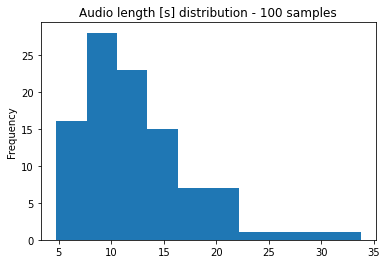

In [ ]:
import matplotlib.pyplot as plt

# Plot the histogram
df.audio_length.plot(kind='hist', bins=10)

# Show the plot
plt.title(f"Audio length [s] distribution - {len(df)} samples")
plt.show()

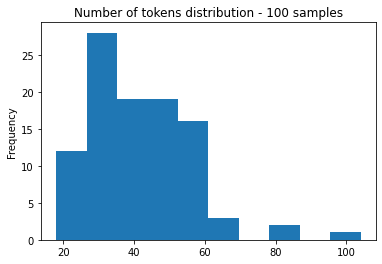

In [ ]:
# Plot the histogram
df.num_tokens.plot(kind='hist', bins=10)

# Show the plot
plt.title(f"Number of tokens distribution - {len(df)} samples")
plt.show()

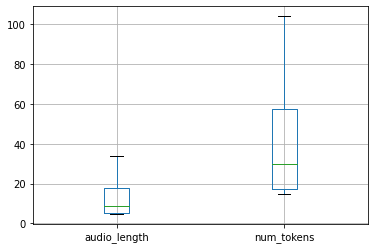

In [ ]:
stats_df = pd.DataFrame({
    "mean": [df.audio_length.mean(), df.num_tokens.mean()],
    "std": [df.audio_length.std(), df.num_tokens.std()],
    "min": [df.audio_length.min(), df.num_tokens.min()],
    "max": [df.audio_length.max(), df.num_tokens.max()],
}, index=["audio_length", "num_tokens"]).T
stats_df
stats_df.boxplot()
plt.show()

From the plots, we can observe that most of the randomly selected examples are shorter than 30 seconds. It is relatively safe to assume then that only a few examples will be truncated during the training. Most of the samples have between 20 and 60 tokens, corresponding to audios between 5 and 20 seconds. Therefore, this dataset might not be the best to fine-tune a model which will then be used to transcribe single words. This is just to remind that we rarely have one dataset which is perfect for all the tasks we want to perform, and it is worth spending some time to understand the dataset before jumping into the training.

Last check: let's have a look the shortest and longest examples (as number of tokens of the reference transcription).

In [ ]:
min_num_tokens = stats_df["num_tokens"]["min"]
max_num_tokens = stats_df["num_tokens"]["max"]
print(f"Min number of tokens: {min_num_tokens}")
print(f"Max number of tokens: {max_num_tokens}")

Min number of tokens: 18.0
Max number of tokens: 104.0


In [ ]:
short_sample = df[df.num_tokens == min_num_tokens].reset_index().iloc[0]
long_sample = df[df.num_tokens == max_num_tokens].reset_index().iloc[0]

In [ ]:
print(short_sample["raw_transcription"])
Audio(short_sample["audio"]["array"], rate=short_sample["audio"]["sampling_rate"])

Jag är glad att det finns människor som är villiga att stötta mig.


In [ ]:
print(long_sample["raw_transcription"])
Audio(long_sample["audio"]["array"], rate=long_sample["audio"]["sampling_rate"])

I hennes andra lopp, storslalom, slutade hon på en tiondeplats i sittgruppen för kvinnor, med en kombinerad tid på 4:41,30. Det var 2:11,60 minuter långsammare än förstaplatsen med österrikiskan Claudia Loesch, och 1:09.02 minuter långsammare än niondeplatsen med ungerskan Gyöngyi Dani.


In [ ]:
import os

from scipy.io.wavfile import write

# This download function is used to embed the files in the blog post.
def save_wav(data, filename, sample_rate, overwrite=False):
    # Create dir if missing
    if not os.path.exists(filename) or overwrite is True:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        write(filename, sample_rate, data)
        print(f"Saved {filename} with sampling rate {sample_rate}")
    else:
        print(f"File {filename} already exists. Skipping.")


In [ ]:
# Save audio files for blog integration
audio_dir = "assets/audio/fleurs_sv"
save_wav(short_sample["audio"]["array"], f"{audio_dir}/short_sample.wav", short_sample["audio"]["sampling_rate"])
save_wav(long_sample["audio"]["array"], f"{audio_dir}/long_sample.wav", long_sample["audio"]["sampling_rate"])
 

Saved assets/audio/fleurs_en/short_sample.wav with sampling rate 16000
Saved assets/audio/fleurs_en/long_sample.wav with sampling rate 16000


## Word Error Rate

Now that we know a bit more about the dataset, we can introduce the [Word Error Rate](https://en.wikipedia.org/wiki/Word_error_rate) (WER) metric. WER measures the amount of errors in the generated transcript - the transcript, from now on - compared with the reference transcript - the reference, from now on - which we assume is the correct one.

Errors can be of three kinds: Insertions (i.e. words that are added in the transcript, but were not present in the reference), Deletions (i.e. words that are present in the reference, but  not in the transcript), and Substitutions (ie. words which are wrongly transcribed, for example `The meat was great!` vs `The meal was great!` has 1 substitution (`meal` -> `meat`).

WER is then calculated as follows:
$$
WER = (S + I + D) / N
$$

where N is the number of words of the reference.

As you can see from the definition, the WER metric measures **only** the amount of words which are wrongly transcribed, with no understanding at all about those differences. Have a look at the following examples, where the first word is the reference, and the second is the transcript:

* `Hi` -> `hi`
* `5` -> `five`
* `cool`-> `cool!`

This list could go longer (currency, units of measure, ...) but you can already see my point. If the text is not normalized before calculating the metric, the results will look much worse than they actually are! So don't forget that important step. Whisper comes with a default normalizer to facilitate experiments comparison, therefore will use that.

Still, if two words are different, one is added, or missed, they will count as 1 Substitution, 1 Insertion, or 1 Deletion respectively, regardlesss of their meanings in the context. Take those two examples:

* `The meal was great` -> `The meal was not great`
* `Ì studied Spanish at school` -> `Ì have studied Spanish at school`

The first Deletion completely swap the sentence meaning, while the second one is basically harmless, but they both impact WER the same way!

Let's now have a look at three random samples from the test split. We will use the implementation provided by 🤗 Evaluate, as we should not reinvent the wheel unless we can make a better one.

In [ ]:
import evaluate
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

metric = evaluate.load("wer")
normalizer = BasicTextNormalizer()

In [ ]:
def wer(pred, label):
    # wer <= 1, we make it as %
    # and it wants list of predictions and references, not strings
    norm_pred = normalizer(pred)
    norm_label = normalizer(label)
    wer = 100 * metric.compute(predictions=[norm_pred], references=[norm_label])

    print("Prediction:", pred)
    print("Reference:", label)
    print("Normalised prediction:", norm_pred)
    print("Normalised reference:", norm_label)
    print("WER", wer)
    return wer

In [ ]:
samples = list(dataset["test"].shuffle(45).take(3))

In [ ]:
for i, sample in enumerate(samples):
    res = transcribe(sample, return_pred_and_ref=True)
    pred, label = res["prediction"], res["label"]
    wer(pred, label)
    if i < len(samples) - 1:
      print("\n", "="*100, "\n")

Audio loaded. Sample rate:  16000
Generating transcription...
Transcription generated in 2.438823389 [s]
Prediction: Europa är kontinent som är relativt liten, men många självstande gillar änder. Under normal omstandigheter skulle resa en flera lander innebär att man måste gå igenom. Vistering sen sökningar är passkantral vid fler tal tillfällen.
Reference: Europa är en kontinent som är relativt liten, men med många självständiga länder. Under normala omständigheter skulle resande genom flera länder innebära att man måste gå igenom viseringsansökningar och passkontroll vid ett flertal tillfällen.
Normalised prediction: europa är kontinent som är relativt liten men många självstande gillar änder under normal omstandigheter skulle resa en flera lander innebär att man måste gå igenom vistering sen sökningar är passkantral vid fler tal tillfällen 
Normalised reference: europa är en kontinent som är relativt liten men med många självständiga länder under normala omständigheter skulle resand

From those examples, we can observe some interesting behavious.

The first sentence is quite innacurate: it fails transcribing the specific service name, as well as the currency. It was a hard one, and I believe it will be a tough one even after fine-tuning, but we will check it again after training.

The second one is perfect! Unfortunately, the normalizer does not convert ordinals to texts, otherwise we would have got a 0 WER.

The third example is perfect as well! The normalizer removes texts within parentheses, but the model failed to predict them. Again, a human would have assigned it a perfect score, while our normalizer dramatically harms the score.

This shows clearly the impact normalization has on WER. However, even worse impact comes from skipping normalization, therefore we will preserve it. To me, it is quite obvious that more time should be spent on optimizing the normalizer, using an iterative approach. And each language should come with its own normalizer.

## Beyond WER

Having seen the limitations of WER, it is worth mentioning that other approaches can be used to either replace or integrate WER. This is a research topic on itself, so I will not write about here, but let me know if you are interested about it and I can make another article about it! Little spolier: I am thinking about using NER to discard Entities like personal or organization names, and using word and sentence embeddings to weight errors. But keep this for you 😉.

## Training

In this paragraph, we will finally fine-tune our model on the dataset we just introduced. Then, we will compare the performance of the original and the fine-tuned models, and we hope to see a decline in the WER.

The paragraph is split into two main parts: in the first one, we will go through the steps required to fine-tune the model using multiple 🤗 libraries. In the second part, we will open the engine and figure out what happens under the hood when the model learns from the training samples.

If you are familiar with fine-tuning Speech Sequence to Sequence models with 🤗, or if you are just curious to know what happens during training, you can jump to the second part. If you don't care about what happens, and you are happy enough with being able to fine-tune a model yourself, the first part will be enough. The full training script and requirement file are available on my [GitHub](https://github.com/marinone94/whisper-inquiry/tree/main/src/whisper_training), and should run out of the box (but go through it, you might need to change a couple of hyperparameters and set the correct flags).

Most of the code comes from the script provided during the 🤗 Whisper Fine-Tuning Event, but it has been slimmed to focus on the essential parts, and it will be expained along the way.

### Fine-tuning Whisper with 🤗


To get started, let's import the required libraries.

In [ ]:
import os  # used to create output directory
import shutil  # used to remove checkpoints before pushing
from dataclasses import dataclass  # used to define data collator
from math import ceil  # used to round up decimals

import evaluate  # used to import and compute evaluation metrics
import torch  # used to know if a GPU with CUDA is available
import wandb  # used for experiment tracking
from datasets import DatasetDict, IterableDatasetDict, load_dataset  # used to load the dataset in streaming mode
from transformers import (
    AutoConfig,  # used to load model configurations
    AutoModelForSpeechSeq2Seq,  # used to load the model architecture and weights
    AutoProcessor,  # used to load the Whisper processor, which includes a feature extractor and a tokenizer
    Seq2SeqTrainer,  # used to perform training and evaluation loops
    Seq2SeqTrainingArguments,  # used to define training hyperparameters
    TrainerCallback,  # used to shuffle the training data after each epoch
    WhisperProcessor  # used for static data typing 
)
from transformers import set_seed  # used for reproducibility
from transformers.models.whisper.english_normalizer import BasicTextNormalizer  # used to normalize transcript and reference before evaluation
from transformers.trainer_pt_utils import IterableDataset, IterableDatasetShard  # used to shuffle the training data after each epoch 


Then, we will load processor, model configuration, architecture and weights, and the dataset (in streaming mode). The Swedish split of Fleurs is not a massive dataset, thus we could easily download it and store it in memory, but it is good to learn how to use the streaming mode if you were to fine-tune your model on larger datasets. 

In [ ]:
model_id = "openai/whisper-tiny"
processor = AutoProcessor.from_pretrained(model_id)
config = AutoConfig.from_pretrained(model_id)
model = AutoModelForSpeechSeq2Seq.from_pretrained(model_id)

Downloading:   0%|          | 0.00/185k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/828 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/494k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/151M [00:00<?, ?B/s]

In [ ]:
dataset_id = "google/fleurs"
dataset_language_code = "sv_se"
dataset = load_dataset(dataset_id, dataset_language_code, streaming=True)

The first time you run this code, make sure everything works fine using a small sample and low number of training steps. Just uncomment the next cell and run it. One note: since the dataset is loaded in streaming mode, the instruction will not be executed immediately. Instead, the dataset will be subsampled only when data will be needed during training.

In [ ]:
test_script = True
# test_script = False

In [ ]:
## Sample dataset for testing
if test_script is True:
    if isinstance(dataset, IterableDatasetDict):
        dataset["train"] = dataset["train"].shuffle(seed=42).take(8)
        dataset["validation"] = dataset["validation"].shuffle(seed=42).take(4)
        dataset["test"] = dataset["test"].shuffle(seed=42).take(4)
    elif isinstance(dataset, DatasetDict):
        dataset["train"] = dataset["train"].shuffle(seed=42).select(range(8))
        dataset["validation"] = dataset["validation"].shuffle(seed=42).select(range(4))
        dataset["test"] = dataset["test"].shuffle(seed=42).select(range(4))

The raw dataset is not yet ready for training. As described in my first article about Whisper, the input audio waveform needs to be transformed into a Log-mel Spectrogram. I recommend you to read the [Audio Preprocessing section](https://marinone94.github.io/Whisper-paper/#audio-preprocessing) to understand the process. For the scope of this article, you should just know that the audio is translated from the time domain to its frequency representation using a sliding window, and adjusted to simulate human hearing. The Whisper Feature Extractor included in the Whisper Processor will take care of the rest.

Furthermore, the reference transcripts need to be tokenized, since the model outputs one token at the time and they are used to compute the loss during training. Again, the Tokenizer will take care of that, but the task needs to be included in the preprocessing step.

When we introduced the WER metric, we learned about the importance of normalizing the texts. But should we do that also before training? That is up to you, but you should remember that Whisper models have been pretrained to predict Capitalization, digits, and punctuation. So if you normalize the reference teanscripts before fine-tuning, you will teach model not to predict capital letters, digits, and punctuations. This does not mean that the model will never predict them, since it has been extensively pretrained to do so. To wrap up, your choice should depend on the final application and the dataset size, but in general I recommend not to normalize the references before training.

Finally, by storing the input features in the default model input name, the trainer will automatically pick the correct ones during training. Thus, don't hard-code it!

In [ ]:
normalizer = BasicTextNormalizer()
# model_input_name = 'input_features'
model_input_name = processor.feature_extractor.model_input_names[0]

def prepare_dataset(batch, normalize=False):
    # process audio
    sample = batch["audio"]
    inputs = processor.feature_extractor(sample["array"], sampling_rate=sample["sampling_rate"])
    # process audio length
    batch[model_input_name] = inputs.get(model_input_name)[0]
    batch["input_length"] = len(sample["array"])

    # process targets
    if normalize is True:
        labels = batch["raw_transcription"].lower()
        labels = normalizer(labels).strip()
    else:
        labels = batch["raw_transcription"].strip()
    batch["labels"] = processor.tokenizer(labels).input_ids
    return batch

We will use the `.map` method to apply our preprocessing function to the whole dataset. At the same time, we will drop all the columns which are not strictly needed during training. Since `input_features`, `ìnput_length` and `labels` are not features of the raw dataset, we can remove all the original ones. Finally, we will convert the dataset features to `torch` type since the dataset has no `__len__`property (again, we are in streaming mode). 

In [ ]:
# dataset["train"].features is like a dict
# train, validation and test splits have the same features
raw_datasets_features = list(dataset["train"].features.keys())
preprocessed_dataset = IterableDatasetDict()

preprocessed_dataset["train"] = dataset["train"].map(
    prepare_dataset,
    remove_columns=raw_datasets_features,
    fn_kwargs={"normalize": False},  # needed only if default value and provided value differ
).with_format("torch")
preprocessed_dataset["validation"] = dataset["validation"].map(
    prepare_dataset,
    remove_columns=raw_datasets_features,
    fn_kwargs={"normalize": False},  # reference transripts are normalized in the evaluation function
).with_format("torch")
preprocessed_dataset["test"] = dataset["test"].map(
    prepare_dataset,
    remove_columns=raw_datasets_features,
    fn_kwargs={"normalize": False},  # reference transripts are normalized in the evaluation function
).with_format("torch")

Since we want to evaluate our model on the validation set during training, we also need to provide a method that computes the metrics given the model predictions. It looks very similar to the function we introduced above, but since it will receive a single prediction object, we need to extract the predicted tokens and the corresponding labels. Furthermore, we replace the label ids equal to -100 with the padding token. A couple of minutes of patience and you will understand why.

When decoding the prediction and the labels, we need to discard the special tokens. Those are used to force the model to perform specific tasks. You can read more [here](https://marinone94.github.io/Whisper-paper/#tasks).

In [ ]:
metric = evaluate.load("wer")

def compute_metrics(pred):
    # extract predicted tokens 
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # pad tokens will then be discarded by the tokenizer with all other special tokens
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # decode transcripts and reference
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # normalize transcript and reference
    pred_str = [normalizer(pred) for pred in pred_str]
    label_str = [normalizer(label) for label in label_str]

    # only evaluate the samples that correspond to non-zero references
    pred_str = [pred_str[i] for i in range(len(pred_str)) if len(label_str[i]) > 0]
    label_str = [label_str[i] for i in range(len(label_str)) if len(label_str[i]) > 0]

    # express WER as percentage
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

Alright, we are almost done preparing our dataset. Quite a lot of work, I know, but that is most of the job.

The last step is to define a data collator, which will build data btaches from the datasets during training using the Whisper Processor. It will also pad input features and labels.

Also, in the metrics computation method we replaced the labels with id equal to -100. It was done because the data collator **must** set the padding tokens to -100 so that the trainer will ignore them when computing the loss. That was the reverse step.

In [ ]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:

    processor: WhisperProcessor
    decoder_start_token_id: int

    def __call__(self, features):
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        model_input_name = self.processor.model_input_names[0]
        input_features = [{model_input_name: feature[model_input_name]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

The next step was something I would have definitely missed had I not attended the 🤗 Whisper Fine-Tuning Event. Thanks, guys, I learned a ton!

Still, there is something misterious to me, so I would love if someone explained it to me. Streaming datasets are not automatically shuffled after each epoch, therefore we define a Callback to do so. However, if we set the number of epochs in the Training Arguments (which we will see shortly), the Trainer complains that the datset has no length, and it asks us to define the maximum number of training steps. So, will this Callback ever be used? Or the Trainer will not be aware of having completed an epoch? Thanks in advance to whoever will clarify this to me! 

In [ ]:
# Trainer callback to reinitialise and reshuffle the streamable datasets at the beginning of each epoch
# Only required for streaming: Trainer automatically shuffles non-streaming datasets
class ShuffleCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, train_dataloader, **kwargs):
        if isinstance(train_dataloader.dataset, IterableDatasetShard):
            pass  # set_epoch() is handled by the Trainer
        elif isinstance(train_dataloader.dataset, IterableDataset):
            train_dataloader.dataset.set_epoch(train_dataloader.dataset._epoch + 1)


We are finally done preparing our data! But do you remember that Whisper is a multi-task Speech Recognition model? And that the task is simply induced using special prefix tokens? Good, now it is time to instruct the model. To do so, we can set those special tokens using the Tokenizer embedded in the Processor.


In [ ]:
processor.tokenizer.set_prefix_tokens(language="sv", task="transcribe")

## If you wanted to get an English transcription from Swedish audio
# processor.tokenizer.set_prefix_tokens(language="sv", task="translate")

(Here you can see what happens if we define only the number of epochs. Scroll down a bit to see explanation and working implementation of Training Arguments and Trainer).

In [ ]:
# Create output dir
output_dir = f"./{your_repo_name}"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="",
    num_train_epochs=2,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=1,
    logging_strategy="steps",
    logging_steps=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=preprocessed_dataset["train"],
    eval_dataset=preprocessed_dataset["validation"],
    tokenizer=processor.feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[ShuffleCallback()]
)

Cool, we are almost ready for training! Let's define (and create, if missing) the output directory and define some Training Arguments. You can read about all the parameterse on the [🤗 docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments).

Here, we will instruct the trainer to both train and evaluate the model, define how often metrics should be logged, evaluation should be performed on the evaluation set, model saved, and what batch size to use. The model - in this configuration - **will not be** pushed to the 🤗 hub since it is quite slow. Make sure to authenticate, create a repo and push your model if you train a large model, or use a large dataset!

We will also use mixed precision (16-bit floating point, or fp16) if we are training on a GPU.

We will also instruct the model to use the `generate` method for evaluation. That method is used for inference, and it applies a decoding technique to the predicted logits. In this case, it will use greedy search, since we set the number of beams to 1. I briefly introduced decoding algorithgms in the [Decoder paragraph](https://marinone94.github.io/Whisper-paper/#decoder) of my first article, but for now you can simply think of it as selecting the next token as the highest probability, after applying a softmax to the logits. I am considering writing a post about the impact of decoding algorithms on Whisper performance, so let me know you are interested!

Last, we can track our training using several experiment tracking tools. I use Weights and Biases - great tool, you should definitely have a look - but 🤗 supports also "azure_ml", "comet_ml", "mlflow", "neptune" and "tensorboard". You can use "all" (default) to report to all integrations installed, "none" for no integrations. Since WandB is installed in this environment, you should explicitely set it to "none" if you don't have an account.

In [ ]:
## If you don't want to track your experiment with WandB, run this!
os.environ["WANDB_DISABLED"] = "true"
report_to = "none"

In [ ]:
# If you have a wandb account, login!
# Otherwise, edit this cell to loging with your favourite experiment tracker(s)
# wandb.login()
# wandb.init(project="whisper-training-post")
# report_to = "wandb"

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: emilio_marinone (pn-aa). Use `wandb login --relogin` to force relogin


In [ ]:
# Check if we have a GPU.
# In case, we will use mixed precision
# to reduce memory footprint with
# with minimal to no harm to performance
device = "cuda" if torch.cuda.is_available() else "cpu"
use_fp16 = (device == "cuda")

# Let's first define the batch sizes
# Increase it if you have more than 16GB GPU
train_bs = 4 if test_script is True else 16
eval_bs = 2 if test_script is True else 8

# Then we infer the number of steps
# TODO: how did I find it?
num_training_samples = 2385
num_epochs = 3
max_steps_full_training = ceil(num_training_samples * num_epochs / train_bs)
max_steps = 2 if test_script is True else max_steps_full_training

# We don't want to evaluate too often since it slows down training a lot
eval_steps = 1 if test_script is True else int(max_steps / 10)
logging_steps = 1 if test_script is True else int(max_steps / 100)

# Init training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    do_train=True,
    do_eval=True,
    max_steps=max_steps,  
    evaluation_strategy="steps",
    eval_steps=eval_steps,
    logging_strategy="steps",
    logging_steps=logging_steps,
    save_strategy="steps",
    save_steps=eval_steps,
    save_total_limit=3,
    learning_rate=7.5e-6,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
	  warmup_ratio=0.5 if test_script is True else 0.3,
    per_device_train_batch_size=train_bs,
    per_device_eval_batch_size=eval_bs,
    # important
    fp16=use_fp16,
    predict_with_generate=True,
    generation_num_beams=1,
    # track experiment
    report_to=report_to,
    # push model to hf hub recommended during training if
    # - training large model / on large datasets (i.e. training takes long)
    # - training on spot instances
    # if the instance crashes, you can resume your training from the checkpoint
    # see 🤗 docs for detailed instructions
    push_model_to_hub=False
)

TypeError: ignored

Now we can provide the trainer with the model, tokenizer (important: use the one you set language and task to! In this example, it is `processor.tokenizer`), training arguments, datasets, data collator, callback, and the method to compute metrics during evaluation.

Note that we don't need to place the model to the accelerator device, nor we had to do it in the data collator with the dataset! The trainer will take care of it, if a GPU is available.

In [ ]:
# Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=preprocessed_dataset["train"],
    eval_dataset=preprocessed_dataset["validation"],
    tokenizer=processor.feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[ShuffleCallback()]
)

max_steps is given, it will override any value given in num_train_epochs
Using cuda_amp half precision backend


I hope you haven't left yet. If you have, bad for you, as we are ready for training our model! 🍾

As Whisper is a pretrained model ready to be used off-the-shelf, it is advisable to evaluate it before training on both the validation and test sets. Let's make sure we make no harm to it.

In [ ]:
eval_metrics = trainer.evaluate(
    eval_dataset=preprocessed_dataset["validation"],
    metric_key_prefix="eval_pretrained",
    max_length=448,
    num_beams=1,
    # gen_kwargs={"key": value}  to provide additional generation specific arguments by keyword
)

trainer.log_metrics("eval_pretrained", eval_metrics)
trainer.save_metrics("eval_pretrained", eval_metrics)
print(eval_metrics)

***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `WhisperForConditionalGeneration.forward` and have been ignored: input_length. If input_length are not expected by `WhisperForConditionalGeneration.forward`,  you can safely ignore this message.


***** eval metrics *****
  eval_loss               =     1.8887
  eval_runtime            = 0:10:23.68
  eval_samples_per_second =      0.632
  eval_steps_per_second   =       0.08
  eval_wer                =    15.5065
{'eval_loss': 1.8887180089950562, 'eval_wer': 15.506522004144824, 'eval_runtime': 623.6849, 'eval_samples_per_second': 0.632, 'eval_steps_per_second': 0.08}


In [ ]:
test_metrics = trainer.evaluate(
    eval_dataset=preprocessed_dataset["test"],
    metric_key_prefix="test_pretrained",
    max_length=448,
    num_beams=1,
    # gen_kwargs={"key": value}  to provide additional generation specific arguments by keyword
)

trainer.log_metrics("test_pretrained", test_metrics)
trainer.save_metrics("test_pretrained", test_metrics)
print(test_metrics)

***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `WhisperForConditionalGeneration.forward` and have been ignored: input_length. If input_length are not expected by `WhisperForConditionalGeneration.forward`,  you can safely ignore this message.


***** test metrics *****
  test_loss               =     1.8868
  test_runtime            = 0:08:36.69
  test_samples_per_second =      1.252
  test_steps_per_second   =      0.157
  test_wer                =    16.1875
{'test_loss': 1.8867595195770264, 'test_wer': 16.187478139209514, 'test_runtime': 516.6931, 'test_samples_per_second': 1.252, 'test_steps_per_second': 0.157}


In [ ]:
train_result = trainer.train()
trainer.save_model()

metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()
print(metrics)


As we can see from the training logs, both the training and evaluation losses have plateaud at a high value, and the evaluation WER has decreased but was fluctuating. There are several reasons for this: however, they go beyond the scope of the article, which is already way too long. Today we focus on HOW to fine-tune the model, and WHAT happens inside the engine. In one of the next ones, we will train the best Whisper model we can. One thing at the time.

Okay, if you really can't wait, I'll spoiler you a couple of things: the model should have been trained longer, with a higher learning rate. And maybe the batch size was too large, considering the dataset size. Hyperparameters should be searched, if compute is available. Or look at others' work, and start from there. That's why open science advances humankind's knowledge at breakneck speed, isn't it?

Alright, let's evaluate it again on the held-out test set.

In [ ]:
final_metrics = trainer.evaluate(
    eval_dataset=preprocessed_dataset["test"],
    metric_key_prefix="test_finetuned",
    max_length=448,
    num_beams=1,
    # gen_kwargs={"key": value}  to provide additional generation specific arguments by keyword
)

trainer.log_metrics("test_finetuned", final_metrics)
trainer.save_metrics("test_finetuned", final_metrics)
print(final_metrics)

***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `WhisperForConditionalGeneration.forward` and have been ignored: input_length. If input_length are not expected by `WhisperForConditionalGeneration.forward`,  you can safely ignore this message.


***** eval metrics *****
  eval_loss               =     1.8887
  eval_runtime            = 0:10:23.68
  eval_samples_per_second =      0.632
  eval_steps_per_second   =       0.08
  eval_wer                =    15.5065
{'eval_loss': 1.8887180089950562, 'eval_wer': 15.506522004144824, 'eval_runtime': 623.6849, 'eval_samples_per_second': 0.632, 'eval_steps_per_second': 0.08}


As we can see, the test WER has dropped 34%, so the fine-tuning is definitely improving the model's performance. But what has happened during training? I mean, we did it all with a single line of code: `trainer.train()`. But to improve your models, fix problems, and come out with innovative solutions, it is essential to deeply understand what happens inside the engine. That is the subject of the next section. But before that, let's clean up our working environment and try out our new model.

As said, during training checkpoints are created. Let's clean up our directory. Don't worry, your best model is saved separately :)

In [ ]:
# Pushing to hub during training slows down training
# so we push it only in the end.
# Since training is completed and best model has been saved,
# we first delete the checkpoints
for filename in os.listdir("."):
    if filename.startswith("checkpoint-"):
        shutil.rmtree(f"./{filename}")

Now we can load the trained model and use it for inference.

In [ ]:
# Get a reference to the first item of the dataset
dataset_head = dataset['test'].take(1)
# Actually download the first item and pprint it
sample = list(dataset_head)[0]

In [ ]:
# Load trained model and do prediction
model = AutoModelForSpeechSeq2Seq.from_pretrained(output_dir).to(device)

In [ ]:
transcribe(sample, print_results=True)

## Inside the engine

- hf supports a lot of approaches, hardware, frameworks, so it does a lot of checks: we will skip them
- model to device
- batch generation
- data to device
- forward pass (compare with previous article and see if we can just reference to it)
    - encoder
    - decoder
- loss
- backprop
- repeat